In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [19]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [20]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [21]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

#[independent_variables.remove(i) for i in columns_to_predict]
independent_variables.remove(columns_to_predict[0])
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
    
print(independent_variables)

['Hour_1', 'Hour_2', 'Hour_3', 'Occupant Count (people)_3', '12h Outdoor Drybulb Temperature (C)', '24h Outdoor Drybulb Temperature (C)', '12h Outdoor Relative Humidity (%)', '6h Direct Solar Radiation (W/m2)', '12h Direct Solar Radiation (W/m2)']


Prepare the data

In [22]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 9)
(96, 9)
(96, 9)


In [23]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [24]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 9), Y_train = (505, 24, 2)
X_val = (25, 48, 9), Y_val = (25, 24, 2)
X_test = (25, 48, 9), Y_test = (25, 24, 2)


In [25]:
print(Y_train[:, :, 0])

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.47416969 0.39741721 0.28594384 ... 0.4397153  0.45619247 0.45482902]
 [0.39741721 0.28594384 0.16805223 ... 0.45619247 0.45482902 0.41836388]
 [0.28594384 0.16805223 0.12974031 ... 0.45482902 0.41836388 0.39162712]]


In [26]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(98, activation='relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(96, activation='relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=100, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])

Epoch 1/100
4/4 [==============================] - 7s 267ms/step - loss: 0.5978 - output_variable1_loss: 0.4028 - output_variable2_loss: 0.1950 - val_loss: 0.4138 - val_output_variable1_loss: 0.2153 - val_output_variable2_loss: 0.1984
Epoch 2/100
4/4 [==============================] - 0s 44ms/step - loss: 0.5590 - output_variable1_loss: 0.3807 - output_variable2_loss: 0.1782 - val_loss: 0.3720 - val_output_variable1_loss: 0.1936 - val_output_variable2_loss: 0.1784
Epoch 3/100
4/4 [==============================] - 0s 45ms/step - loss: 0.5013 - output_variable1_loss: 0.3371 - output_variable2_loss: 0.1641 - val_loss: 0.3642 - val_output_variable1_loss: 0.1983 - val_output_variable2_loss: 0.1659
Epoch 4/100
4/4 [==============================] - 0s 46ms/step - loss: 0.4485 - output_variable1_loss: 0.2951 - output_variable2_loss: 0.1534 - val_loss: 0.3242 - val_output_variable1_loss: 0.1646 - val_output_variable2_loss: 0.1596
Epoch 5/100
4/4 [==============================] - 0s 45ms/step

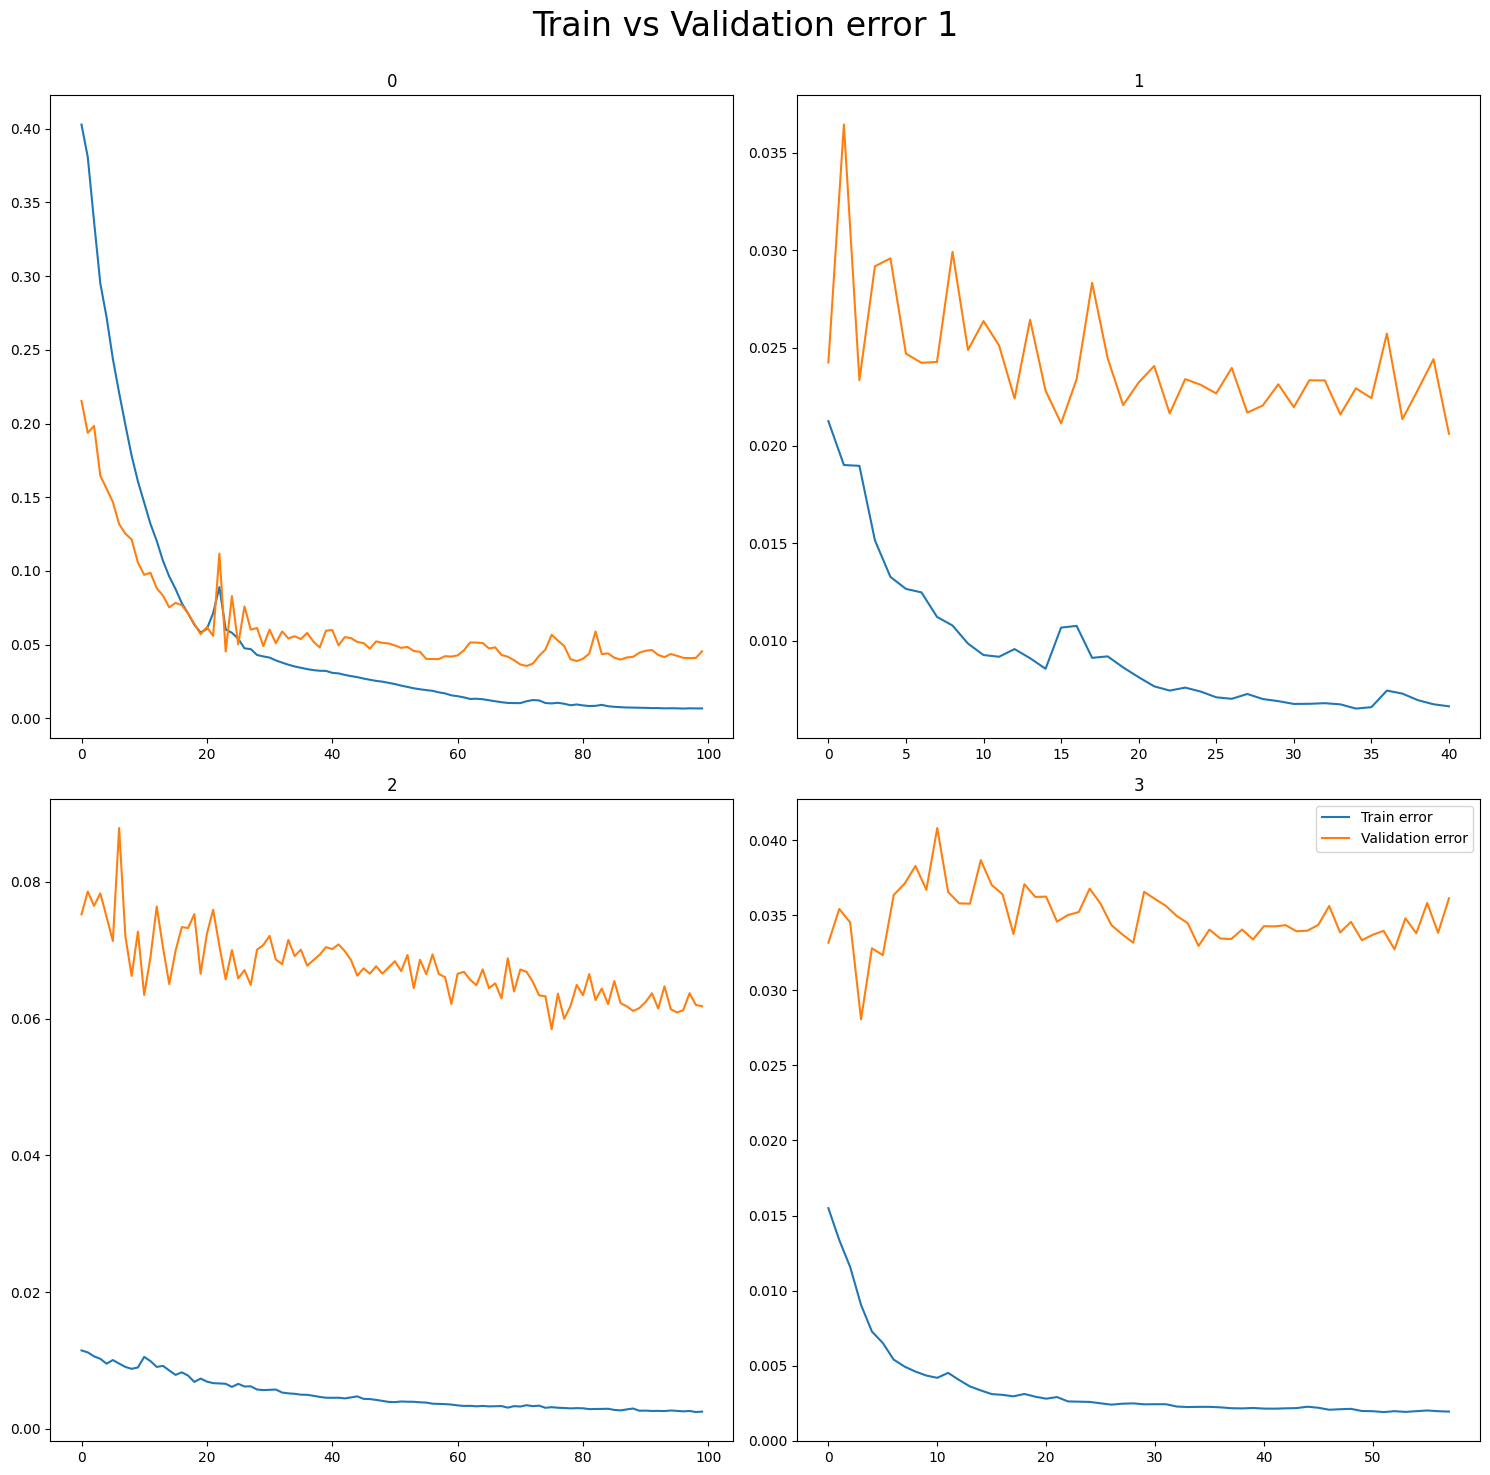

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

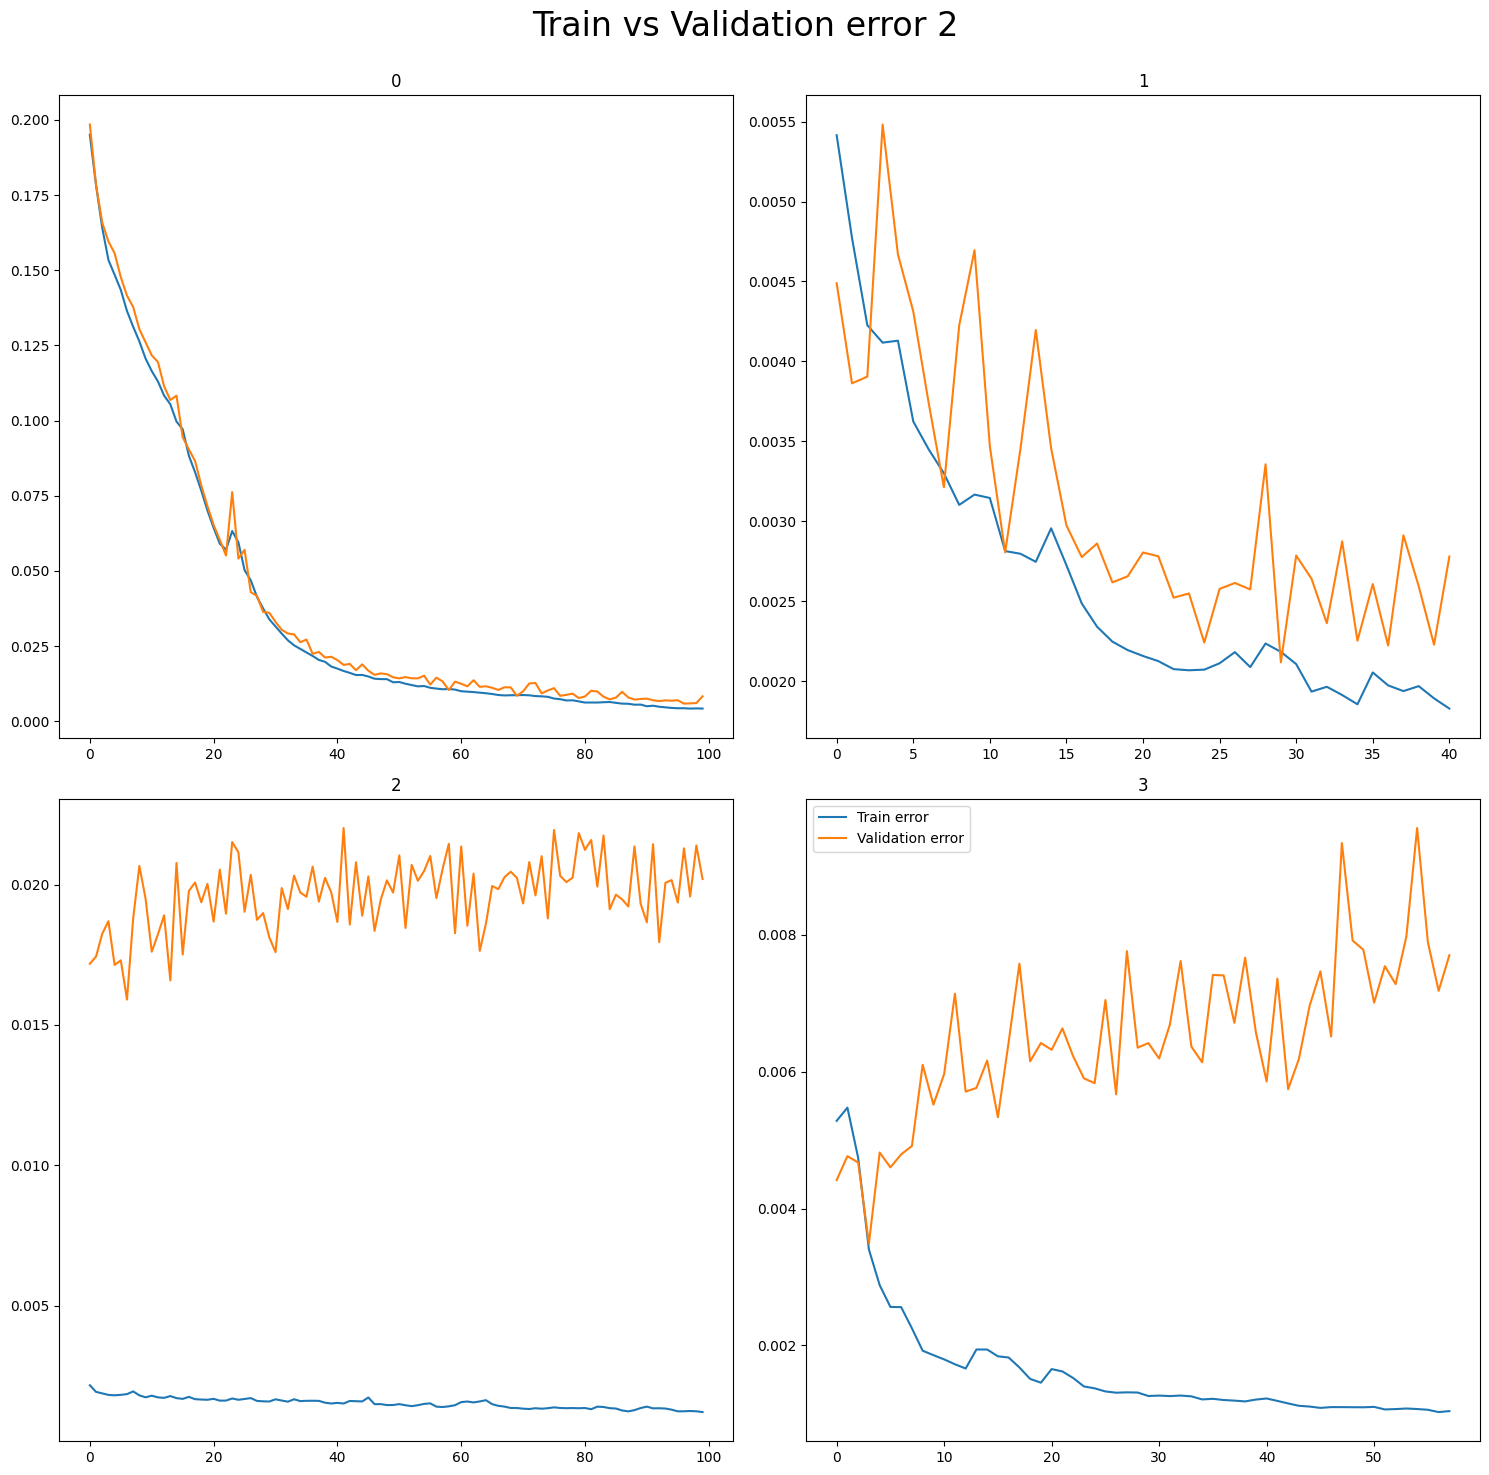

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

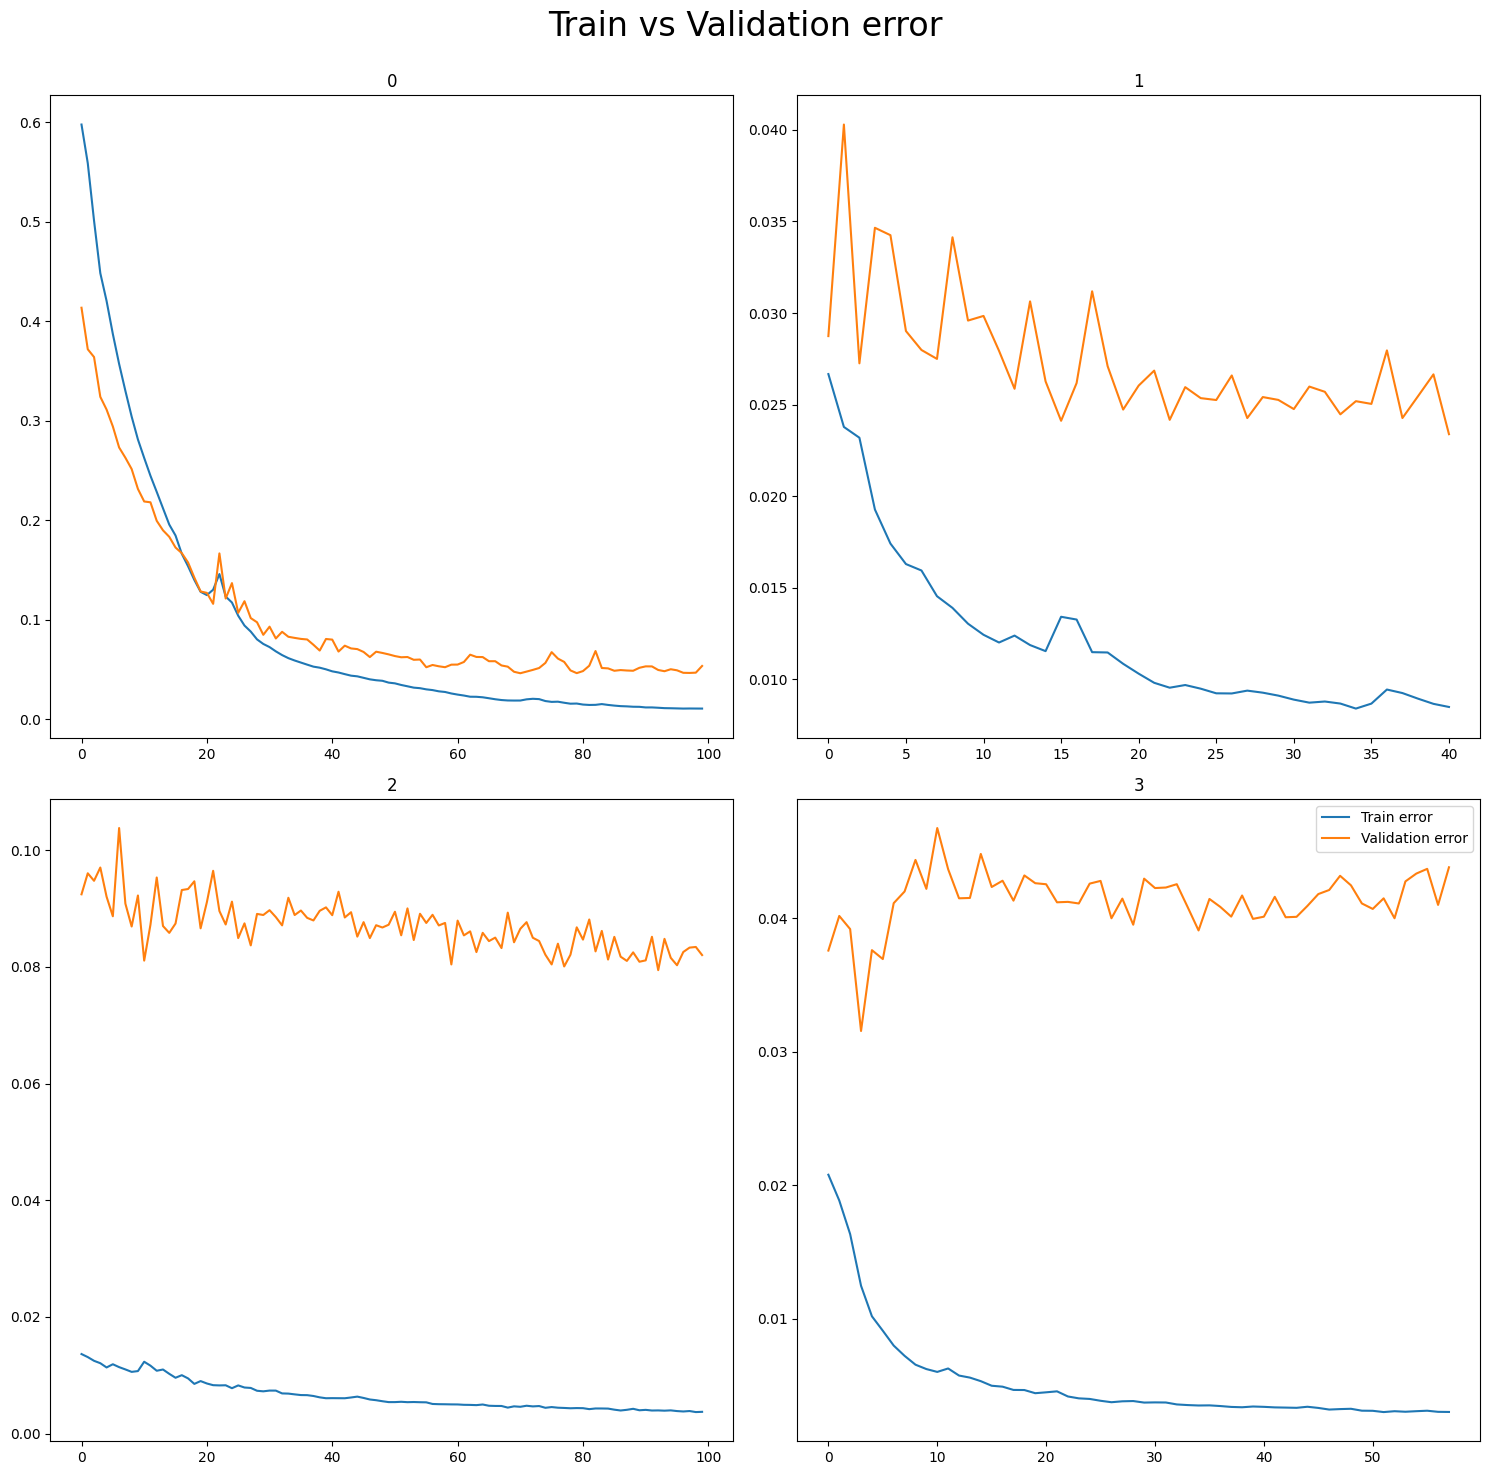

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [30]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 19ms/step


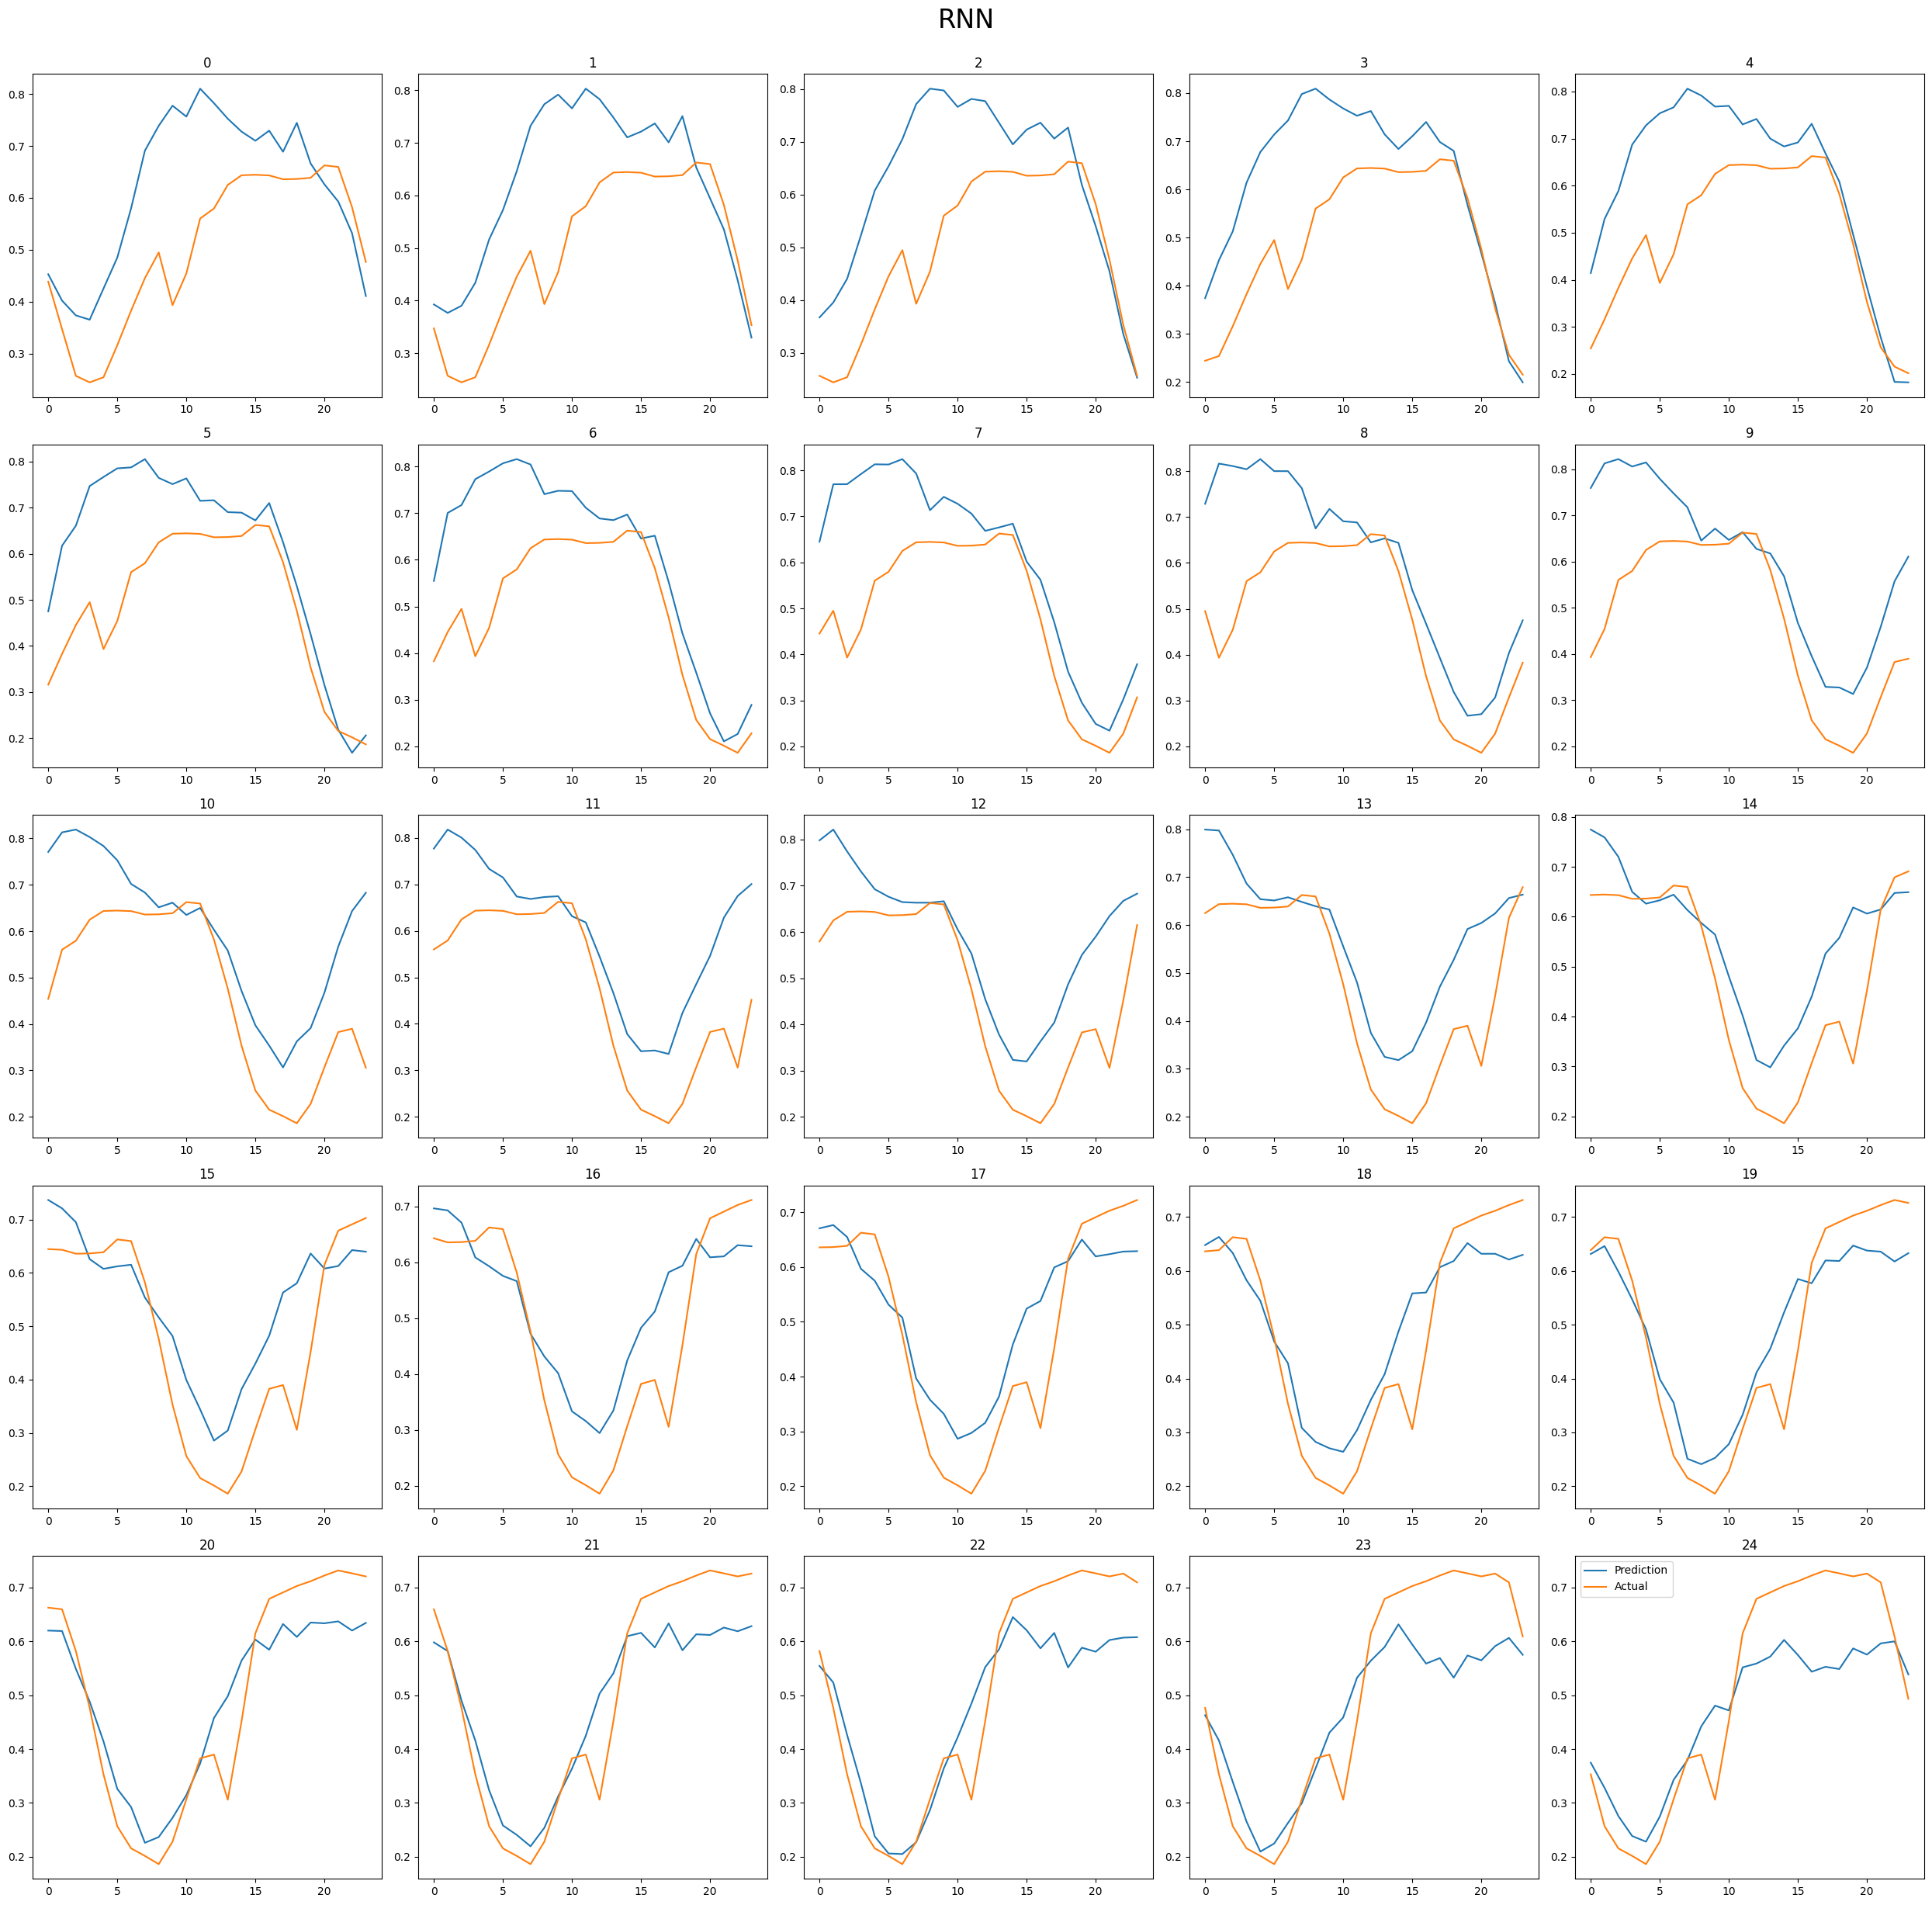

In [31]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

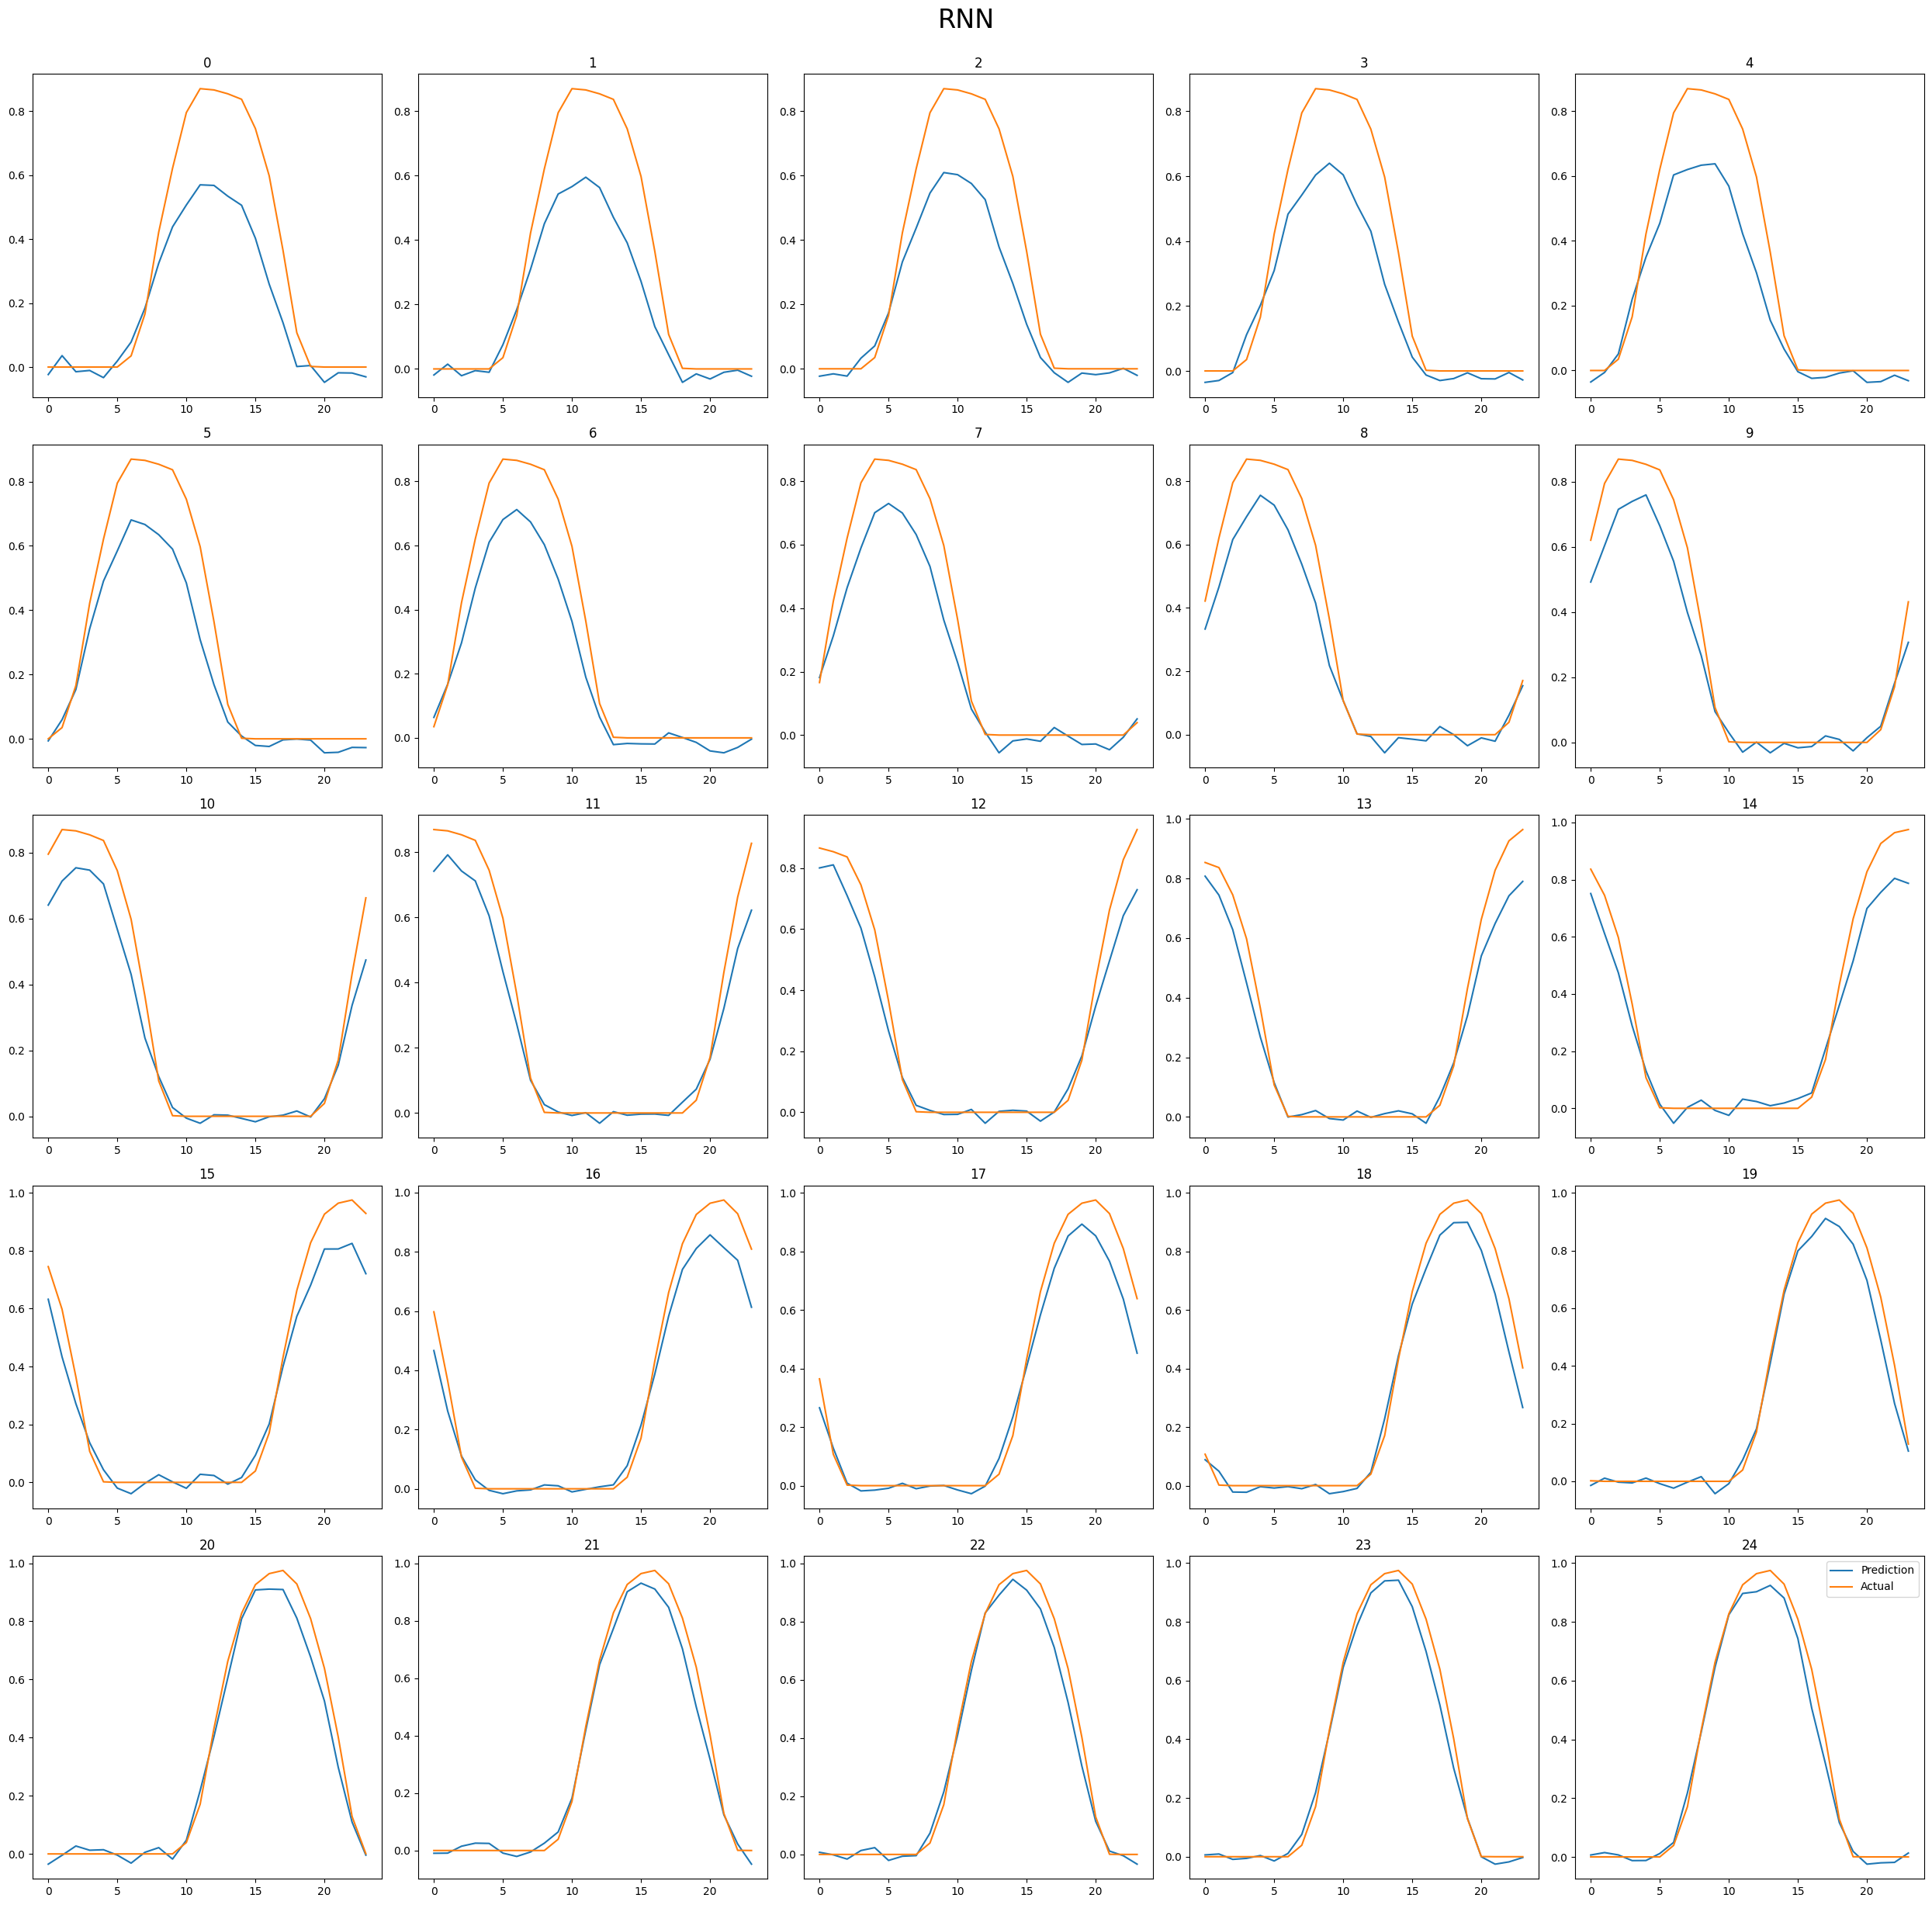

In [32]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [33]:
rmse = 0
for i in range(len(predictions_1)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

pred=0, num = 0.1651345725599623
pred=1, num = 0.1677769382889109
pred=2, num = 0.16953351685717288
pred=3, num = 0.16688006905868014
pred=4, num = 0.1619947317345164
pred=5, num = 0.16112628722206723
pred=6, num = 0.16208879747914168
pred=7, num = 0.1627263277669831
pred=8, num = 0.16449260455480927
pred=9, num = 0.16632574400633082
pred=10, num = 0.1691565229937362
pred=11, num = 0.15993198362811828
pred=12, num = 0.14366693296100413
pred=13, num = 0.12790333212636962
pred=14, num = 0.11907282602141304
pred=15, num = 0.11175210474110851
pred=16, num = 0.10359867525890609
pred=17, num = 0.09165679796687609
pred=18, num = 0.08272146944255031
pred=19, num = 0.07796638083436888
pred=20, num = 0.07679292648943711
pred=21, num = 0.08111624713986167
pred=22, num = 0.09089865946854112
pred=23, num = 0.09960751018106867
pred=24, num = 0.10447340008000208
RMSE = 0.13153581435447745


In [34]:
rmse = 0
for i in range(len(predictions_2)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

pred=0, num = 0.18502632753143952
pred=1, num = 0.18101844648370563
pred=2, num = 0.17370746795507902
pred=3, num = 0.1653898642536204
pred=4, num = 0.15152729338305468
pred=5, num = 0.1372207367608492
pred=6, num = 0.125282237697403
pred=7, num = 0.11545506270056832
pred=8, num = 0.10538213017810981
pred=9, num = 0.0991363759282399
pred=10, num = 0.0940477734709614
pred=11, num = 0.08848245208622771
pred=12, num = 0.08831804815106019
pred=13, num = 0.08618871757462575
pred=14, num = 0.08879071964818996
pred=15, num = 0.09020298822724813
pred=16, num = 0.08224356706050019
pred=17, num = 0.07893740547129233
pred=18, num = 0.07196970116188867
pred=19, num = 0.06044527024622939
pred=20, num = 0.05533989467405545
pred=21, num = 0.050093585466020774
pred=22, num = 0.04745378508063541
pred=23, num = 0.04682235235773166
pred=24, num = 0.042804719829651984
RMSE = 0.10045147693513558
